<a href="https://colab.research.google.com/github/prathwishshetty/causalML/blob/causalDSBoston/model_tests_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Causal Data Science Analysis of Airbnb Listings**

This is a notebook on the tests that were run on the model. For variable explainantion, refer to `Causal Data Science Notebook`

The following packages are the requirements for this notebook.

* `bnlearn`
* `arules`
* `BiocManager`
* `Rgraphviz` 

# Global Markov and faithfulness assumption tests

1. The very first step is to create a model2network to create the bayesian network.
2. The next step is to calculate the combinatorics that calculates all the pairs to compare, i.e. the 'x' and 'y' arguments in `d_sep`.  For each pair, all subsets of size 0 - 4 variables that are not in that pair are calculated.  Each pair / other variable subset combination is an element in the `arg_sets` list.

3. We iterate through the list of argument sets and evaluate if the d-separation statement is true. If a statement is true, we add it to the list. 

4. The `ci.test` function in `bnlearn` does statistical tests for conditional independence.  The null hypothesis in this test is that the conditional independence is true.  So our decision critera is going to be:

> If p value is below a .05 significance threshold, conclude that the conditional independence statement is false  Otherwise conclude it is true.

5. We calculated the golobal Markov property by checking the proportion of true D-separation statements that are also true conditional independence statements which comes out to be approximately

6. A joint distribution $P_{\mathbb{X}}$ is **faithful** to DAG ${\mathbb{G}}$ if $A \perp_{P_{\mathbb{X}}}B|C \Rightarrow  A \perp_{\mathbb{G} }B|C$ for all disjoint vertex set A, B, C. In other words, every true conditional independence statement about the joint distribution corresponds to a true d-separation statement in the DAG  Iterate through the `arg_sets` list again for calculating the faithfulness assumption.

In [0]:
install.packages('bnlearn',repos='http://cran.us.r-project.org')
install.packages('arules',repos='http://cran.us.r-project.org')
install.packages('tidyverse',repos='http://cran.us.r-project.org')
install.packages("BiocManager")
BiocManager::install("Rgraphviz")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.3 (2020-02-29)

Installing package(s) 'Rgraphviz'

Old packages: 'backports', 'broom', 'curl', 'dbplyr', 'devtools', 'farver',
  'fs', 'gdtools', 'glue', 'isoband', 'lubridate', 'pkgbuild', 'processx',
  'purrr', 'Rcpp', 'reshape2', 'rex', 'rprojroot', 'systemfonts', 'tibble',
  'tinytex', 'usethis', 'withr', 'xfun', 'xml2', 'boot', 'class', 'KernSmooth',
  'MASS', 'nlme', 'nnet', 'spatial', 'survival'



In [0]:
library('bnlearn')
library('tidyverse')
library('Rgraphviz')
library('dplyr')
library('arules')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.0     ✔ stringr 1.4.0
✔ tidyr   1.0.2     ✔ forcats 0.5.0
✔ readr   1.3.1     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ stringr::boundary() masks graph::boundary()
✖ dplyr::combine()    masks BiocGenerics::combine()
✖ tidyr::expand()     masks Matrix::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ tidyr::pack()       masks Matrix::pack()
✖ ggplot2::Position() masks BiocGenerics::Position(), base::Position()
✖ arules::recode()    masks dplyr::recode()
✖ tidyr::unpack()     masks Matrix::unpack()



# Data

In [0]:
df <-read.csv('data/listings_full.csv')

# Initial DAG

In [0]:
dag1 <- empty.graph(nodes = c('amenities_score','bathrooms','bedrooms','transitScore','Zestimate',
                            'zipcode','roi','price','minimum_nights_avg_ntm','maximum_nights_avg_ntm'))

In [0]:
arc.set <- matrix(c('amenities_score','price',
                    'bathrooms','price',
                    'bathrooms','Zestimate',
                    'bedrooms','price',
                    'bedrooms','Zestimate',
                    'price','roi',
                    'transitScore','Zestimate',
                    'Zestimate', 'price',
                    'Zestimate','roi',
                    'zipcode','price',
                    'zipcode','transitScore',
                    'minimum_nights_avg_ntm','price',
                    'maximum_nights_avg_ntm','price'),
                    byrow = TRUE, ncol = 2,
                    dimnames = list(NULL, c("from", "to")))
arcs(dag1) <- arc.set

In [0]:
#@title
beautifulDAG <- function(nodeList,edgesMat){
    graph <- new("graphNEL", nodes=nodeList, edgemode="directed")

    for (i in 1:dim(edgesMat)[1]){
        graph <- addEdge(edgesMat[[i,1]],edgesMat[[i,2]],graph)
        }

    nAttrs <- list()
    eAttrs <- list()
    z <- nodeList
    z <- z[1:numNodes(graph)]
    names(z) = nodes(graph)
    nAttrs$label <- z

    options(repr.plot.width = 30, repr.plot.height = 15)
    attrs <- list(node=list(shape="ellipse", fixedsize=FALSE))
    attrs$node$fontsize <- 40
    return(plot(graph,nodeAttrs=nAttrs, attrs=attrs))
}

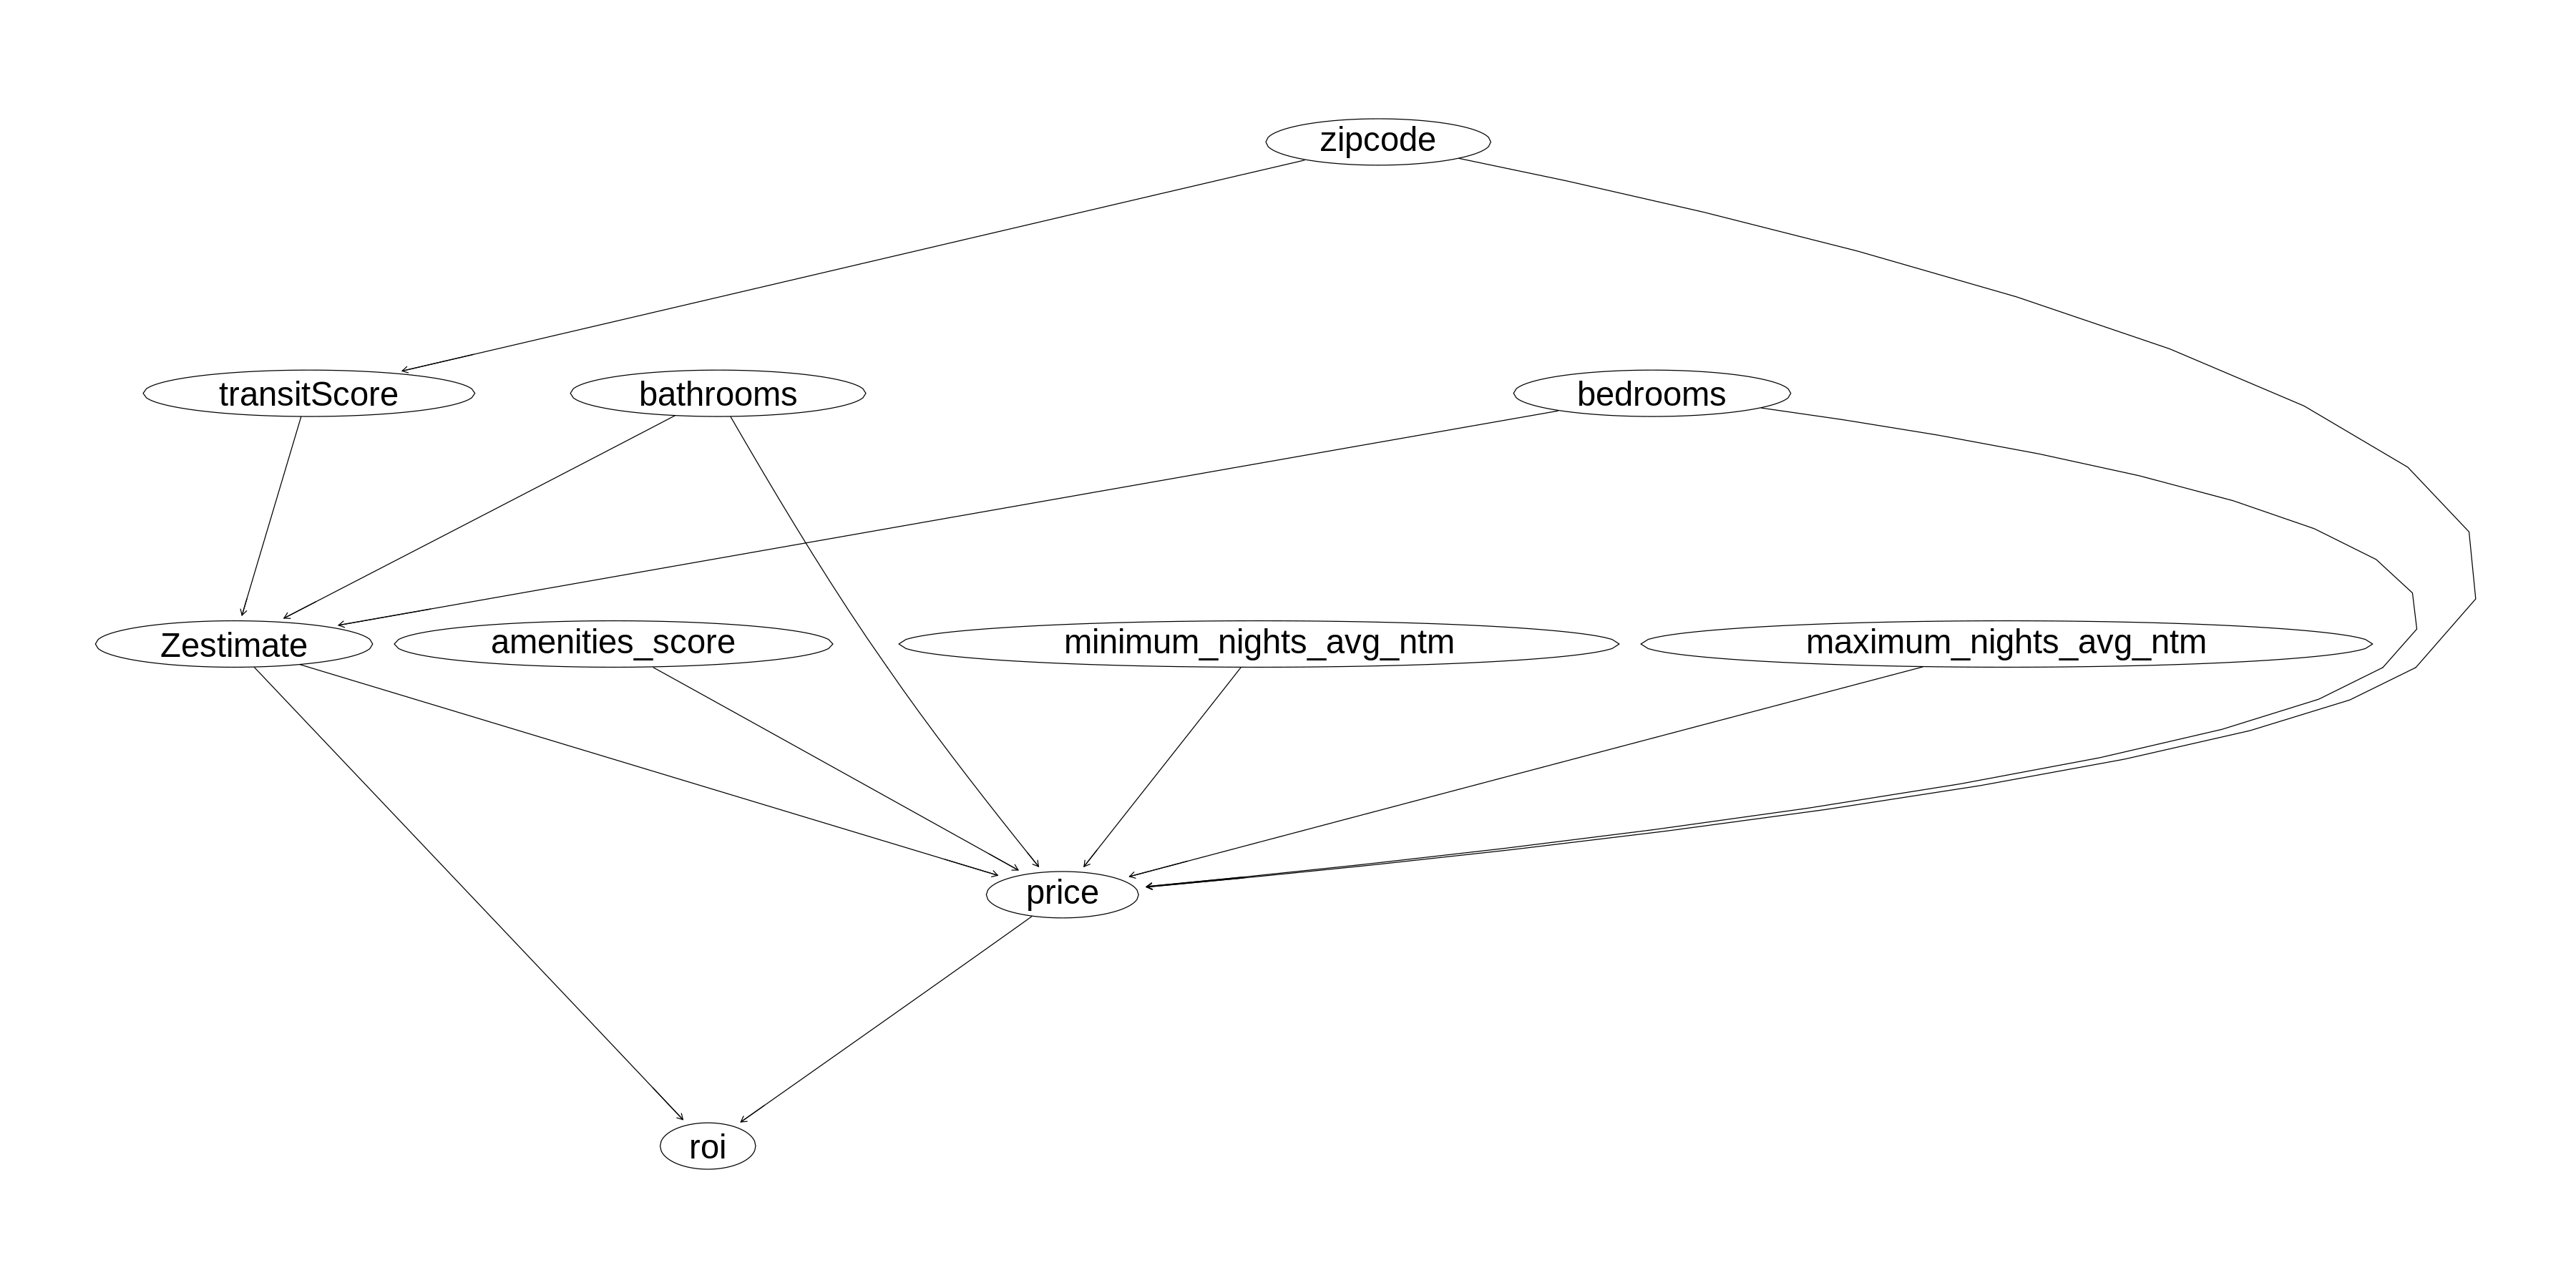

In [0]:
beautifulDAG(nodes(dag1),arcs(dag1))

## Data Filtering

Filtering our the columns needed for the initial DAG

In [0]:
data1 <- df %>% select(amenities_score,
                        bathrooms,
                        bedrooms,
                        transitScore,
                        Zestimate,
                        zipcode,
                        roi,
                        price,
                        minimum_nights_avg_ntm,
                        maximum_nights_avg_ntm)


In [0]:
data1$bathrooms <- as.factor(data1$bathrooms)
data1$transitScore <- as.factor(data1$transitScore)
data1$zipcode <- as.factor(data1$zipcode)

data1$maximum_nights_avg_ntm <- discretize(data1$maximum_nights_avg_ntm ,method = "interval", breaks = 3)

In [0]:
factor_names <- names(data1)[which(map_lgl(data1, ~ class(.x) == "factor"))]

In [0]:
data1_fac <-data1 %>% select(-factor_names) %>%
            mutate(amenities_score = as.numeric(amenities_score),
                	bedrooms= as.numeric(bedrooms),
                	Zestimate=as.numeric(Zestimate),
                	roi=as.numeric(roi),
                    price=as.numeric(price),
                	minimum_nights_avg_ntm=as.numeric(minimum_nights_avg_ntm)) %>%
    bnlearn::discretize(method = "hartemink", breaks = 3, ibreaks=3) %>%
    cbind(select(data1, factor_names))

data1<- data1_fac

Warning message in check.discretization.args(method, data, breaks, list(...)):
“the initial number of breaks is identical to the final number of breaks.”


### 1. model2network

In [0]:
net = model2network("[bathrooms][bedrooms][amenities_score][zipcode][minimum_nights_avg_ntm][maximum_nights_avg_ntm][price|Zestimate:amenities_score:maximum_nights_avg_ntm:minimum_nights_avg_ntm:bathrooms:bedrooms:zipcode][Zestimate|transitScore:bathrooms:bedrooms][transitScore|zipcode][roi|Zestimate:price]")

In [0]:
d_sep <- bnlearn:::dseparation

### 2. Argument set calculation

In [0]:
vars <- nodes(net)
pairs <- combn(x = vars, 2, list)
arg_sets <- list()
for(pair in pairs){
  others <- setdiff(vars, pair)
  conditioning_sets <- unlist(lapply(0:4, function(.x) combn(others, .x, list)), recursive = F)
  for(set in conditioning_sets){
    args <- list(x = pair[1], y = pair[2], z = set)
    arg_sets <- c(arg_sets, list(args)) 
  }
}

In [0]:
length(arg_sets)

[1] 7335

### 3. true dseparation

In [0]:
True_dsep <- list()
count = 0
  for(i in arg_sets){
      truedsep <- d_sep(bn=net, x=i$x, y=i$y, z=i$z)
        if (truedsep == TRUE){
          True_dsep = c(True_dsep, list(i))
           count <- count + 1
    }
  }
  
print(count)

[1] 1385


### 4. ci test

In [0]:
class(data1$amenities_score)

[1] "factor"

In [0]:
knitr::opts_chunk$set(warning = FALSE, message= FALSE)
True_dsep = c(True_dsep, list(args)) 
    c<-0
    for(i in True_dsep){ 
      test_outcome <- ci.test(i$x,  i$y , i$z , data1)
    
      alpha <- 0.05
      if(test_outcome$p.value <= alpha){
        print(test_outcome)
        print(test_outcome$p.value)
        print(test_outcome$p.value <= alpha)   
}
    }


	Mutual Information (disc.)

data:  amenities_score ~ bathrooms  
mi = 18.442, df = 8, p-value = 0.01815
alternative hypothesis: true value is greater than 0

[1] 0.0181464
[1] TRUE

	Mutual Information (disc.)

data:  amenities_score ~ bedrooms  
mi = 12.024, df = 4, p-value = 0.01717
alternative hypothesis: true value is greater than 0

[1] 0.01717163
[1] TRUE

	Mutual Information (disc.)

data:  amenities_score ~ bedrooms | minimum_nights_avg_ntm
mi = 25.762, df = 12, p-value = 0.0116
alternative hypothesis: true value is greater than 0

[1] 0.01159901
[1] TRUE

	Mutual Information (disc.)

data:  amenities_score ~ bedrooms | maximum_nights_avg_ntm + minimum_nights_avg_ntm
mi = 55.427, df = 36, p-value = 0.02027
alternative hypothesis: true value is greater than 0

[1] 0.02026594
[1] TRUE

	Mutual Information (disc.)

data:  amenities_score ~ bedrooms | minimum_nights_avg_ntm + Zestimate
mi = 66.552, df = 36, p-value = 0.001451
alternative hypothesis: true value is greater than 0



In [0]:
cond_indep <- list()
alpha <- .05
  for(i in arg_sets){
    test_outcome <- ci.test(i$x,  i$y , i$z , data1)
    if (test_outcome$p.value > alpha){
      cond_indep <- c(cond_indep, list(i))
    }
    
  }



### 5. Global Markov property

In [0]:
##True conditional inpdendence statements among true d-separation statements - Global Markov property
ratio <- list()
count <- 0
  for(i in True_dsep){
    test_outcome <- ci.test(i$x,  i$y , i$z , data1)
    alpha <- .05
    #otpt <- d_sep(bn=net, x=args$x, y=args$y, z=args$z)
    if (test_outcome$p.value > alpha){
      count <- count+1
      ratio <- c(ratio, test_outcome$p.value > alpha)
      
    }
    
  }

print(paste('the proportion of true D-separation statements that are also true conditional independence statements', count/length(True_dsep)))

[1] "the proportion of true D-separation statements that are also true conditional independence statements 0.958152958152958"


### 6. Faithfulness Assumption

In [0]:
### True d-separation statements among true conditional inpdendence statements - Faithfulness assumption
newratio <- list()
count <- 0
for (i in cond_indep)
{
  res <- d_sep(bn= net, x=i$x, y=i$y, z=i$z)
  if(res == TRUE)
 {
 count <- count + 1
 }
} 

print(paste('the proportion of true conditional independence statements that are also true-deseparation statements',count/length(cond_indep)))

[1] "the proportion of true conditional independence statements that are also true-deseparation statements 0.190032937133037"


# Final DAG

In [0]:
dag2 <- empty.graph(nodes = c('amenities_score','bathrooms','bedrooms','transitScore','Zestimate',
                             'neighbourhood','roi','price','minimum_nights_avg_ntm', 'bikeScore','walkScore',
                             'publicSchoolScores','property_type',
                             'closenessToDowntown','accommodates','beds'))

In [0]:
arc.set <- matrix(c('amenities_score','price',
                    'bathrooms','price',
                    'bathrooms','Zestimate',
                    'bedrooms','price',
                    'bedrooms','beds',
                    'bedrooms','accommodates',
                    'bedrooms','Zestimate',
                    'property_type','price',
                    'property_type','Zestimate',
                    'price','roi',
                    'transitScore','Zestimate',
                    'transitScore','price',
                    'Zestimate', 'price',
                    'bikeScore','price',
                    'walkScore','price',
                    'beds','price',
                    'accommodates','price',
                    'Zestimate','roi',
                    'neighbourhood','price',
                    'neighbourhood','transitScore',
                    'neighbourhood','publicSchoolScores',
                    'publicSchoolScores','Zestimate',
                    'neighbourhood','Zestimate',
                    'neighbourhood','closenessToDowntown',
                    'closenessToDowntown','price',                    
                    'minimum_nights_avg_ntm','price'),
                    byrow = TRUE, ncol = 2,
                    dimnames = list(NULL, c("from", "to")))
arcs(dag2) <- arc.set

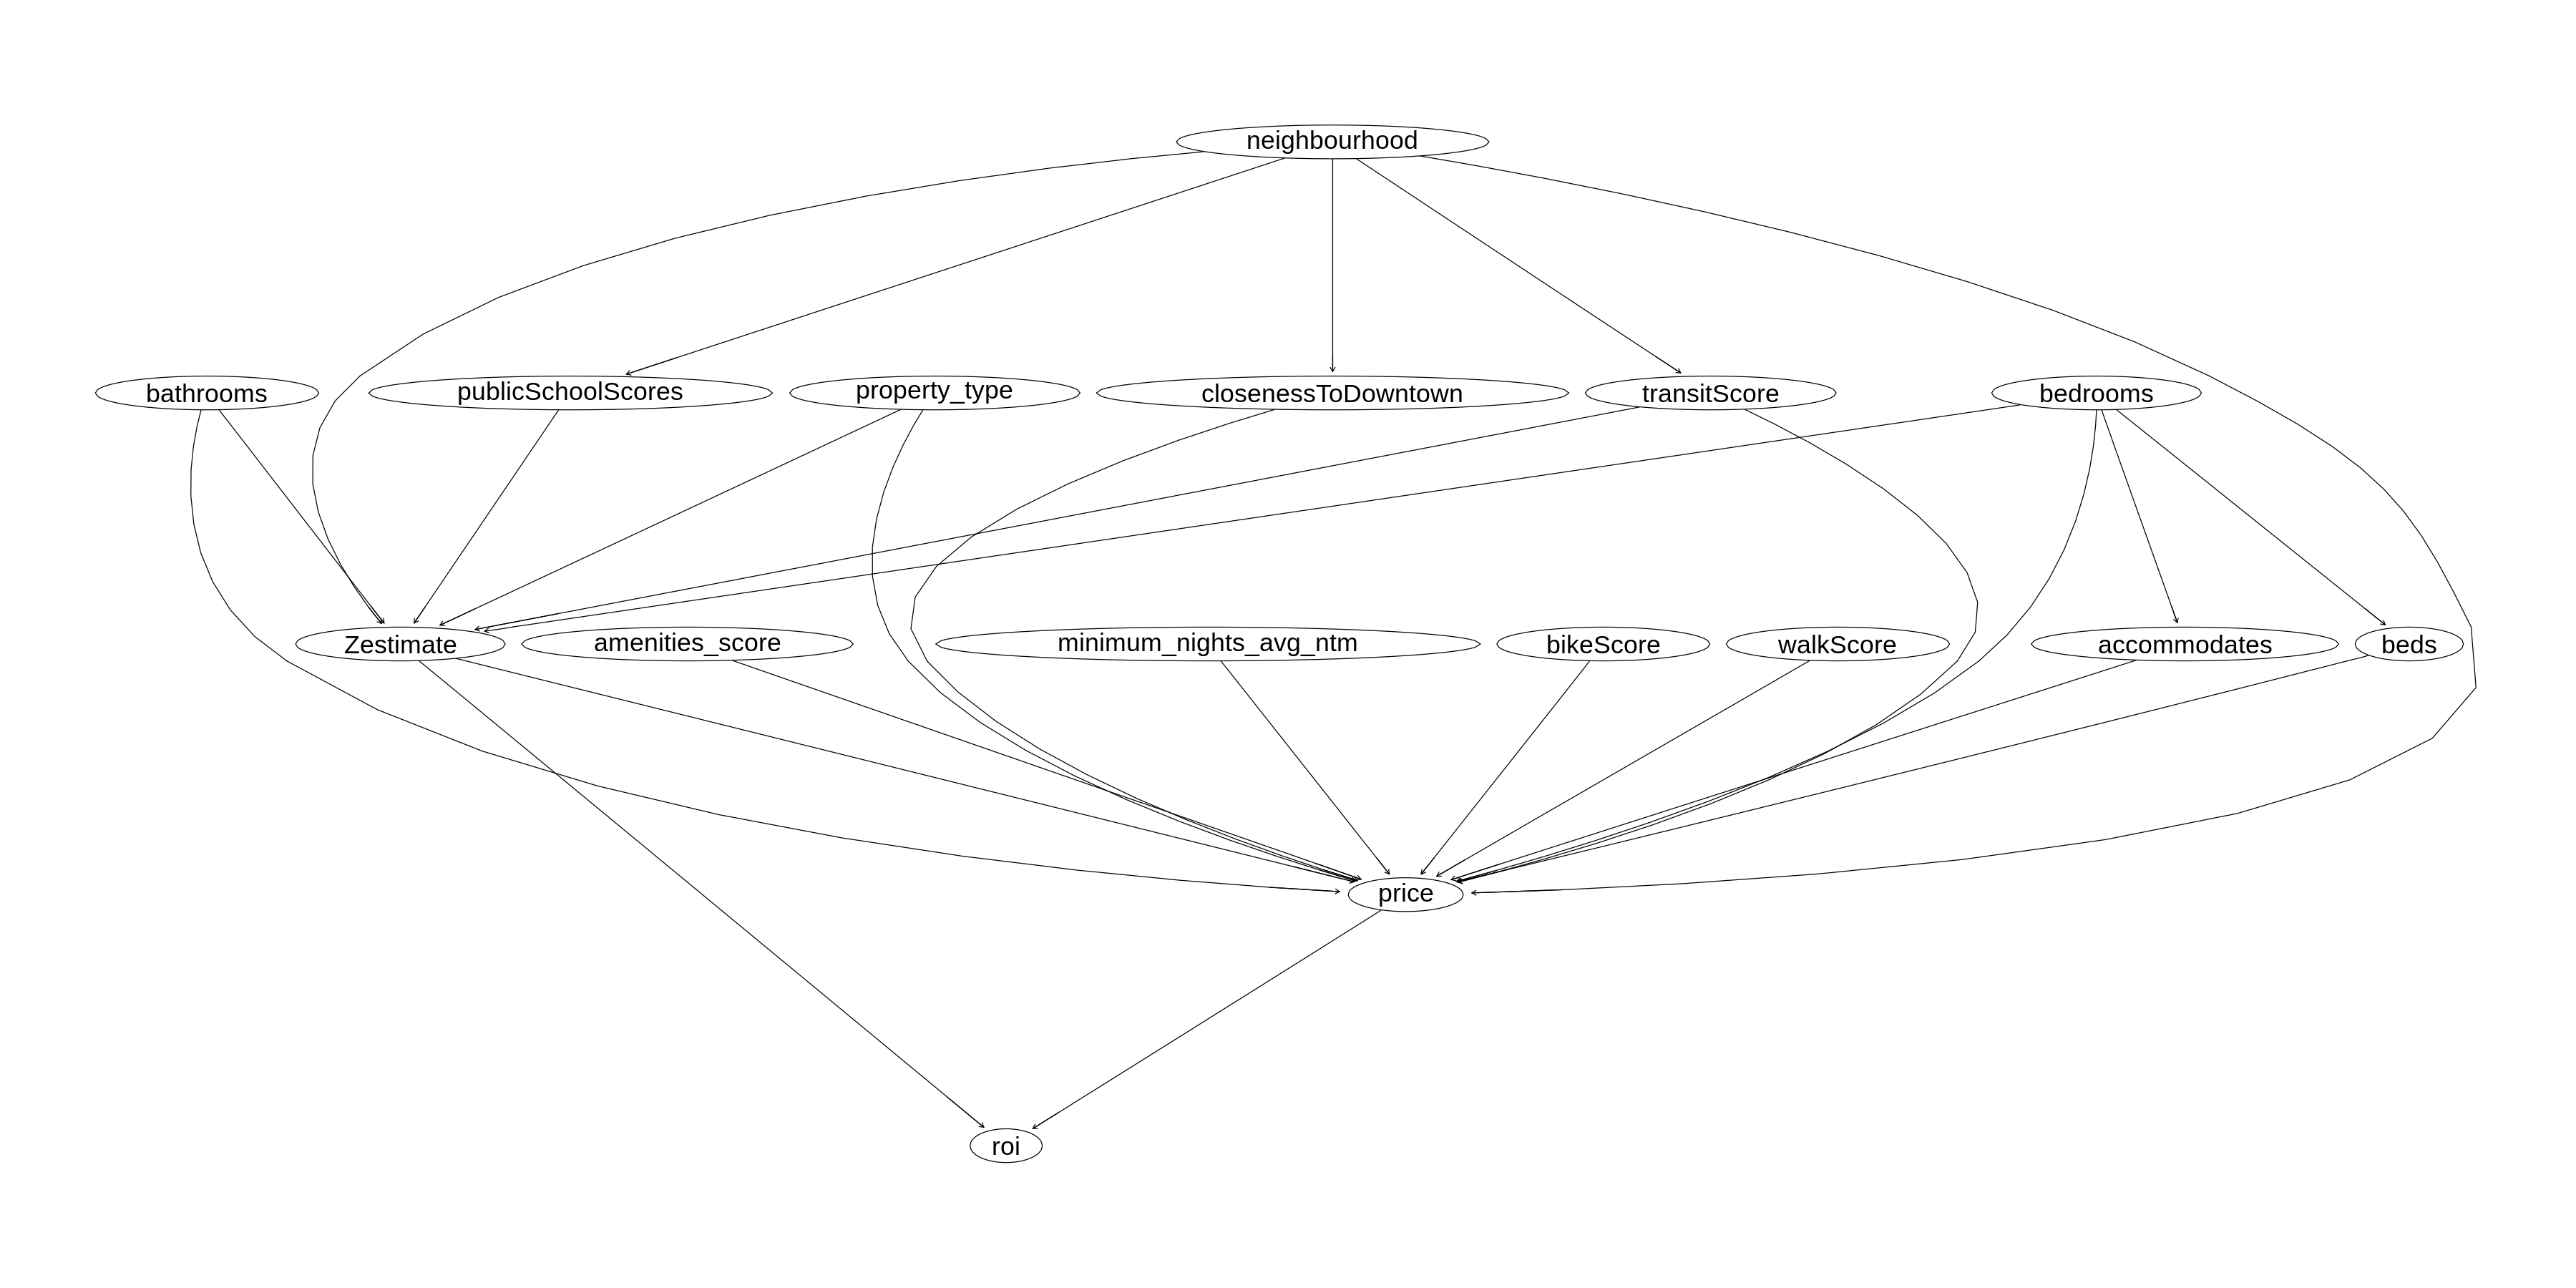

In [0]:
beautifulDAG(nodes(dag2),arcs(dag2))

## Data Filtering

In [0]:
data2 <- df %>% select(amenities_score,
                       bathrooms,
                       bedrooms,
                       transitScore,
                       Zestimate,
                       neighbourhood,
                       roi,
                       price,
                       minimum_nights_avg_ntm,
                       bikeScore,
                       walkScore,
                       publicSchoolScores,
                       property_type,
                       closenessToDowntown,
                       accommodates,
                       beds)

In [0]:
data2$bathrooms <- as.factor(data2$bathrooms)
data2$transitScore <- as.factor(data2$transitScore)
data2$zipcode <- as.factor(data2$neighbourhood)
data2$bikeScore <- as.factor(data2$bikeScore)
data2$walkScore <- as.factor(data2$walkScore)
data2$property_type <- as.factor(data2$property_type)

In [0]:
factor_names <- names(data2)[which(map_lgl(data2, ~ class(.x) == "factor"))]

In [0]:
data2_fac <-data2 %>% select(-factor_names) %>%
            mutate(amenities_score = as.numeric(amenities_score),
                	bedrooms= as.numeric(bedrooms),
                	Zestimate=as.numeric(Zestimate),
                	roi=as.numeric(roi),
                    price=as.numeric(price),
                	minimum_nights_avg_ntm=as.numeric(minimum_nights_avg_ntm),
                    publicSchoolScores=as.numeric(publicSchoolScores),
                    closenessToDowntown=as.numeric(closenessToDowntown),
                    accommodates=as.numeric(accommodates),
                    beds=as.numeric(beds)) %>%
    bnlearn::discretize(method = "hartemink", breaks = 3, ibreaks=3) %>%
    cbind(select(data2, factor_names))

data2<- data2_fac

### model2network

In [0]:
#model2network
net = model2network("[neighbourhood][bathrooms][minimum_nights_avg_ntm][property_type][bedrooms][amenities_score][bikeScore][walkScore][beds][publicSchoolScores|neighbourhood][closenessToDowntown|neighbourhood][price|Zestimate:property_type:transitScore:closenessToDowntown:amenities_score:minimum_nights_avg_ntm:bikeScore:walkScore:accommodates:beds:bathrooms:bedrooms:neighbourhood][Zestimate|neighbourhood:transitScore:publicSchoolScores:property_type:closenessToDowntown:bathrooms:bedrooms][transitScore|neighbourhood][roi|Zestimate:price][accommodates|bedrooms][beds|bedrooms]")

In [0]:
vars <- nodes(net)
pairs <- combn(x = vars, 2, list)
arg_sets <- list()
for(pair in pairs){
  others <- setdiff(vars, pair)
  conditioning_sets <- unlist(lapply(0:4, function(.x) combn(others, .x, list)), recursive = F)
  for(set in conditioning_sets){
    args <- list(x = pair[1], y = pair[2], z = set)
    arg_sets <- c(arg_sets, list(args)) 
  }
}

ERROR: ignored

In [0]:
print(paste("number of arg sets formed:",length(arg_sets)))

[1] "number of arg sets formed: 200526"


### true dseparation

In [0]:
True_dsep <- list()
count = 0
  for(i in arg_sets){
      truedsep <- d_sep(bn=net, x=i$x, y=i$y, z=i$z)
        if (truedsep == TRUE){
          True_dsep = c(True_dsep, list(i))
           count <- count + 1
    }
  }
print(paste('the number of true d-separation:',count))

[1] "the number of true d-separation: 62048"


### ci test

In [0]:
knitr::opts_chunk$set(warning = FALSE, message= FALSE)
True_dsep = c(True_dsep, list(args)) 
    c<-0
    for(i in True_dsep){ 
      test_outcome <- ci.test(i$x,  i$y , i$z , data2)
    
      alpha <- 0.05
      if(test_outcome$p.value <= alpha){
        print(test_outcome)
        print(test_outcome$p.value)
        print(test_outcome$p.value <= alpha)
      
}
}


	Mutual Information (disc.)

data:  accommodates ~ amenities_score  
mi = 22.182, df = 4, p-value = 0.0001844
alternative hypothesis: true value is greater than 0

[1] 0.0001843505
[1] TRUE

	Mutual Information (disc.)

data:  accommodates ~ amenities_score | beds
mi = 24.086, df = 12, p-value = 0.0198
alternative hypothesis: true value is greater than 0

[1] 0.01980121
[1] TRUE

	Mutual Information (disc.)

data:  accommodates ~ amenities_score | bikeScore
mi = 29.551, df = 16, p-value = 0.02048
alternative hypothesis: true value is greater than 0

[1] 0.02047743
[1] TRUE

	Mutual Information (disc.)

data:  accommodates ~ amenities_score | closenessToDowntown
mi = 40.247, df = 12, p-value = 6.542e-05
alternative hypothesis: true value is greater than 0

[1] 6.542296e-05
[1] TRUE

	Mutual Information (disc.)

data:  accommodates ~ amenities_score | minimum_nights_avg_ntm
mi = 35.127, df = 12, p-value = 0.000447
alternative hypothesis: true value is greater than 0

[1] 0.0004470082
[1

### true conditional statement

In [0]:
cond_indep <- list()
alpha <- .05
  for(i in arg_sets){
    if (i$x != i$y){
    test_outcome <- ci.test(i$x,  i$y , i$z , data2)
    }
    if (test_outcome$p.value > alpha){
      cond_indep <- c(cond_indep, list(i))
    }
  }

In [0]:
## True conditional inpdendence statements among true d-separation statements - Global Markov property
ratio <- list()
count <- 0
  for(i in True_dsep){
    test_outcome <- ci.test(i$x,  i$y , i$z , data2)
    alpha <- .05
    #otpt <- d_sep(bn=net, x=args$x, y=args$y, z=args$z)
   
    if (test_outcome$p.value > alpha){
      count <- count+1
      ratio <- c(ratio, test_outcome$p.value > alpha)
    }
  }

print(paste('the proportion of true D-separation statements that are also true conditional independence statements', count/length(True_dsep)))

[1] "the proportion of true D-separation statements that are also true conditional independence statements 0.984995729181776"


In [0]:
###  True d-separation statements among true conditional inpdendence statements - Faithfulness assumption
newratio <- list()
count <- 0
for (i in cond_indep)
{
  res <- d_sep(bn= net, x=i$x, y=i$y, z=i$z)
  if(res == TRUE)
 {
 count <- count + 1
 }
} 
print(paste('the proportion of true conditional independence statements that are also true-deseparation statements',count/length(cond_indep)))

[1] "the proportion of true conditional independence statements that are also true-deseparation statements 0.311563911460935"
